In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


In [2]:
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient

In [3]:
import missingno as msno
def visualize_ms(clients_ms_datas:list, sort_patterns: bool = False):
    n_cols = 5
    n_clients = len(clients_ms_datas)
    n_rows = (n_clients + 4)//n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3), squeeze=False)
    for i in range(n_clients):
        ax = axes[i//n_cols, i%n_cols]
        d = pd.DataFrame(clients_ms_datas[i])
        d = d.sort_values(by=d.columns[-1])
        if sort_patterns:
            msno.matrix(d, ax=ax, sparkline=False, sort='ascending')
        else:
            msno.matrix(d, ax=ax, sparkline=False)
        ax.set_title('Client {}'.format(i))
    plt.tight_layout()

def correlation(original_data, centralized_data):
    from dython.nominal import correlation_ratio
    original_df = pd.DataFrame(original_data)
    target_col = original_df.columns[-1]
    correlation_ret = original_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

    centralized_df = pd.DataFrame(centralized_data)
    target_col = centralized_df.columns[-1]
    correlation_ret = centralized_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

def sklearn_evaluation(ret):
    from sklearn.neural_network import MLPClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics

    original_data = ret['data']['origin_data'].reshape(-1, 23)
    print(original_data.shape)
    centralized_data = ret['data']['imputed_data'].reshape(-1, 23)
    print(centralized_data.shape)
    test_data = ret['data']['test_data']
    print(test_data.shape)

    X_train = centralized_data[:, :-1]
    y_train = centralized_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    clf = MLPClassifier([32, 32], batch_size = 128, random_state=21, alpha = 0.001, max_iter = 500).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy imputed centralized MLP:", metrics.accuracy_score(y_test, y_pred))

    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy imputed centralized LR:", metrics.accuracy_score(y_test, y_pred))

    clf = RandomForestClassifier(n_estimators = 200, random_state=0).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy imputed centralized RF:", metrics.accuracy_score(y_test, y_pred))

    X_train = original_data[:, :-1]
    y_train = original_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    clf = MLPClassifier([32, 32], batch_size = 128, random_state=21, alpha = 0.001, max_iter=500).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy all clients complete data centralized MLP:", metrics.accuracy_score(y_test, y_pred))

    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy all clients complete data centralized MLP:", metrics.accuracy_score(y_test, y_pred))

    clf = RandomForestClassifier(n_estimators = 200, random_state=0).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy all clients complete data centralized MLP:", metrics.accuracy_score(y_test, y_pred))

In [4]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 0.8,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    "scale_factor": 4
  }
}

In [5]:
def show_missing_mech(datas, masks, feature_idx):
    n_cols = 6
    n_rows = len(datas) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), squeeze=False)
    for i in range(len(datas)):
        df = pd.DataFrame(datas[i])
        target = df.columns[-1]
        series1 = df.iloc[masks[i][:, feature_idx], feature_idx]
        df[feature_idx].hist(ax=ax[i // n_cols, i % n_cols], alpha=0.5, label='0')
        series1.hist(ax=ax[i // n_cols, i % n_cols], alpha=0.5, label='1')
        ax[i // n_cols, i % n_cols].set_title(f'Client {i}')
    plt.tight_layout()

## IJCNN

In [81]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced_pca'
config['num_clients'] = 40
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.05'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

datamss = [client.X_train_ms for client in clients.values()]
msks = [client.missing_mask for client in clients.values()]
datas = [np.concatenate([client.X_train, client.y_train.reshape(-1,1)], axis = 1) for client in clients.values()]

sample {'p': '0.05'}
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv
ridge logistic_cv


In [34]:
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor

In [82]:
data0 = data[data[data_config['target']] == 0]
data1 = data[data[data_config['target']] == 1]
data0 = data0.values[:, :-1]
data1 = data1.values[:, :-1]

In [32]:
for feature_idx in range(data0.shape[1]):
    y0 = data0[:, feature_idx]
    y1 = data1[:, feature_idx]
    X0 = np.delete(data0, feature_idx, axis=1)
    X1 = np.delete(data1, feature_idx, axis=1)

    model0 = RidgeCV().fit(X0, y0)
    model1 = RidgeCV().fit(X1, y1)
    y_pred1 = model0.predict(X1)
    y_pred11 = model1.predict(X1)
    y_pred0 = model1.predict(X0)
    y_pred00 = model0.predict(X0)
    print("====================================================")
    print('Feature {}'.format(feature_idx))
    print(np.mean(np.abs(y_pred1 - y1)))
    print(np.mean(np.abs(y_pred11 - y1)))
    print(np.mean(np.abs(y_pred0 - y0)))
    print(np.mean(np.abs(y_pred00 - y0)))

Feature 0
0.21398649323451036
0.15544858371748363
0.2825275692388653
0.20730018034738767
Feature 1
0.13906672450568144
0.12855425079760935
0.14780938625452159
0.14033261848182166
Feature 2
0.13689409163274333
0.13306969353530118
0.14057098121679806
0.1356977440986571
Feature 3
0.18179907713238916
0.15738792261320633
0.19489450172446518
0.17789594237230602
Feature 4
0.1895213367176179
0.18015930602934943
0.18302236618726508
0.1832781603637326
Feature 5
0.18870810318593217
0.18774672150046443
0.18858219289333122
0.18865476928257216
Feature 6
0.29277911846557514
0.29198629715065205
0.2929291230758676
0.29386635337578415
Feature 7
0.3235990726889966
0.32222453537647927
0.32232447974156664
0.3209974377737216
Feature 8
0.306872328485379
0.3050864345916738
0.3087144666321334
0.30771512698437037
Feature 9
0.3217334345726325
0.32047774581860666
0.3214922546323232
0.3191118033025877
Feature 10
0.16013617587231813
0.08332690944360345
0.20117520861185315
0.14088744091523978
Feature 11
0.0670126517

In [35]:
for feature_idx in range(data0.shape[1]):
    y0 = data0[:, feature_idx]
    y1 = data1[:, feature_idx]
    X0 = np.delete(data0, feature_idx, axis=1)
    X1 = np.delete(data1, feature_idx, axis=1)

    model0 = MLPRegressor([32, 32]).fit(X0, y0)
    model1 = MLPRegressor([32, 32]).fit(X1, y1)
    y_pred1 = model0.predict(X1)
    y_pred11 = model1.predict(X1)
    y_pred0 = model1.predict(X0)
    y_pred00 = model0.predict(X0)
    print("====================================================")
    print('Feature {}'.format(feature_idx))
    print(np.mean(np.abs(y_pred1 - y1)))
    print(np.mean(np.abs(y_pred11 - y1)))
    print(np.mean(np.abs(y_pred0 - y0)))
    print(np.mean(np.abs(y_pred00 - y0)))

Feature 0
0.07699617679087757
0.056725995369398215
0.08900422098127954
0.05903462384922916
Feature 1
0.008276680897885837
0.007759487010093707
0.011965076481237132
0.007463751727328292
Feature 2
0.009944175626015886
0.005196604072638486
0.007698429198388242
0.006624988684974185
Feature 3
0.013992718723809732
0.0064550762157440855
0.010158391876677431
0.010851810719126814
Feature 4
0.010987121766158606
0.006107586046559288
0.008792178905514036
0.00768643644602858
Feature 5
0.011266899969440552
0.009710063463196306
0.013308107267551933
0.009425547395966356
Feature 6
0.015397797136381787
0.014815679444301144
0.020019740883018174
0.012557188667649516
Feature 7
0.021811166253968298
0.011436140709178937
0.01935424878681255
0.01621467085397699
Feature 8
0.013530379808406436
0.012212768123796883
0.016088047096108313
0.010628283772646966
Feature 9
0.010846455876600653
0.012290230716950913
0.019033994021099735
0.008793737947826135
Feature 10
0.07603920445823506
0.051508358699779135
0.18589328114

In [99]:
from sklearn.preprocessing import KBinsDiscretizer

feature_idx = [1, 2, 3, 4, 5]
data_ = data.copy()
for feature_i in feature_idx:
    f0 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform').fit_transform(data_.values[:, feature_i].reshape(-1, 1))
    data_.iloc[:, feature_i] = f0.reshape(-1)
pd.crosstab([data_[feature_id] for feature_id in feature_idx], data_['class'], normalize='index', margins=True)

class               0         1
1   2   3                      
0.0 0.0 0.0  1.000000  0.000000
        1.0  1.000000  0.000000
        2.0  1.000000  0.000000
        3.0  0.455959  0.544041
    1.0 0.0  0.578999  0.421001
        1.0  0.428571  0.571429
        2.0  0.818182  0.181818
        3.0  0.458065  0.541935
    2.0 0.0  0.848485  0.151515
        1.0  1.000000  0.000000
        2.0  0.594463  0.405537
        3.0  0.142857  0.857143
    3.0 1.0  1.000000  0.000000
        2.0  0.565217  0.434783
1.0 0.0 0.0  0.593861  0.406139
        1.0  0.218447  0.781553
        2.0  0.642857  0.357143
        3.0  0.400000  0.600000
    1.0 0.0  0.498552  0.501448
        1.0  0.498474  0.501526
        2.0  0.560777  0.439223
        3.0  0.407432  0.592568
    2.0 0.0  0.936508  0.063492
        1.0  0.704048  0.295952
        2.0  0.437141  0.562859
    3.0 0.0  1.000000  0.000000
        1.0  0.773723  0.226277
        2.0  0.416107  0.583893
2.0 0.0 0.0  0.066667  0.933333
        1.0  0.661836  0.338164
        2.0  0.439689  0.560311
    1.0 0.0  0.491194  0.508806
        1.0  0.726003  0.273997
        2.0  0.477756  0.522244
        3.0  0.333333  0.666667
    2.0 0.0  0.657534  0.342466
        1.0  0.438763  0.561237
        2.0  0.565476  0.434524
        3.0  0.456832  0.543168
    3.0 0.0  0.641221  0.358779
        1.0  0.312500  0.687500
        2.0  0.250000  0.750000
        3.0  0.232558  0.767442
3.0 0.0 1.0  1.000000  0.000000
        2.0  0.505155  0.494845
    1.0 0.0  0.500000  0.500000
        1.0  0.300000  0.700000
        2.0  0.435065  0.564935
        3.0  0.250000  0.750000
    2.0 0.0  0.542636  0.457364
        1.0  0.250000  0.750000
        2.0  0.571429  0.428571
        3.0  0.602740  0.397260
    3.0 2.0  1.000000  0.000000
        3.0  0.333333  0.666667
All          0.500000  0.500000

In [107]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

X, y = data.iloc[:, 0:3], data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
clf = RandomForestClassifier(n_estimators = 200, random_state=0).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8466340933767644


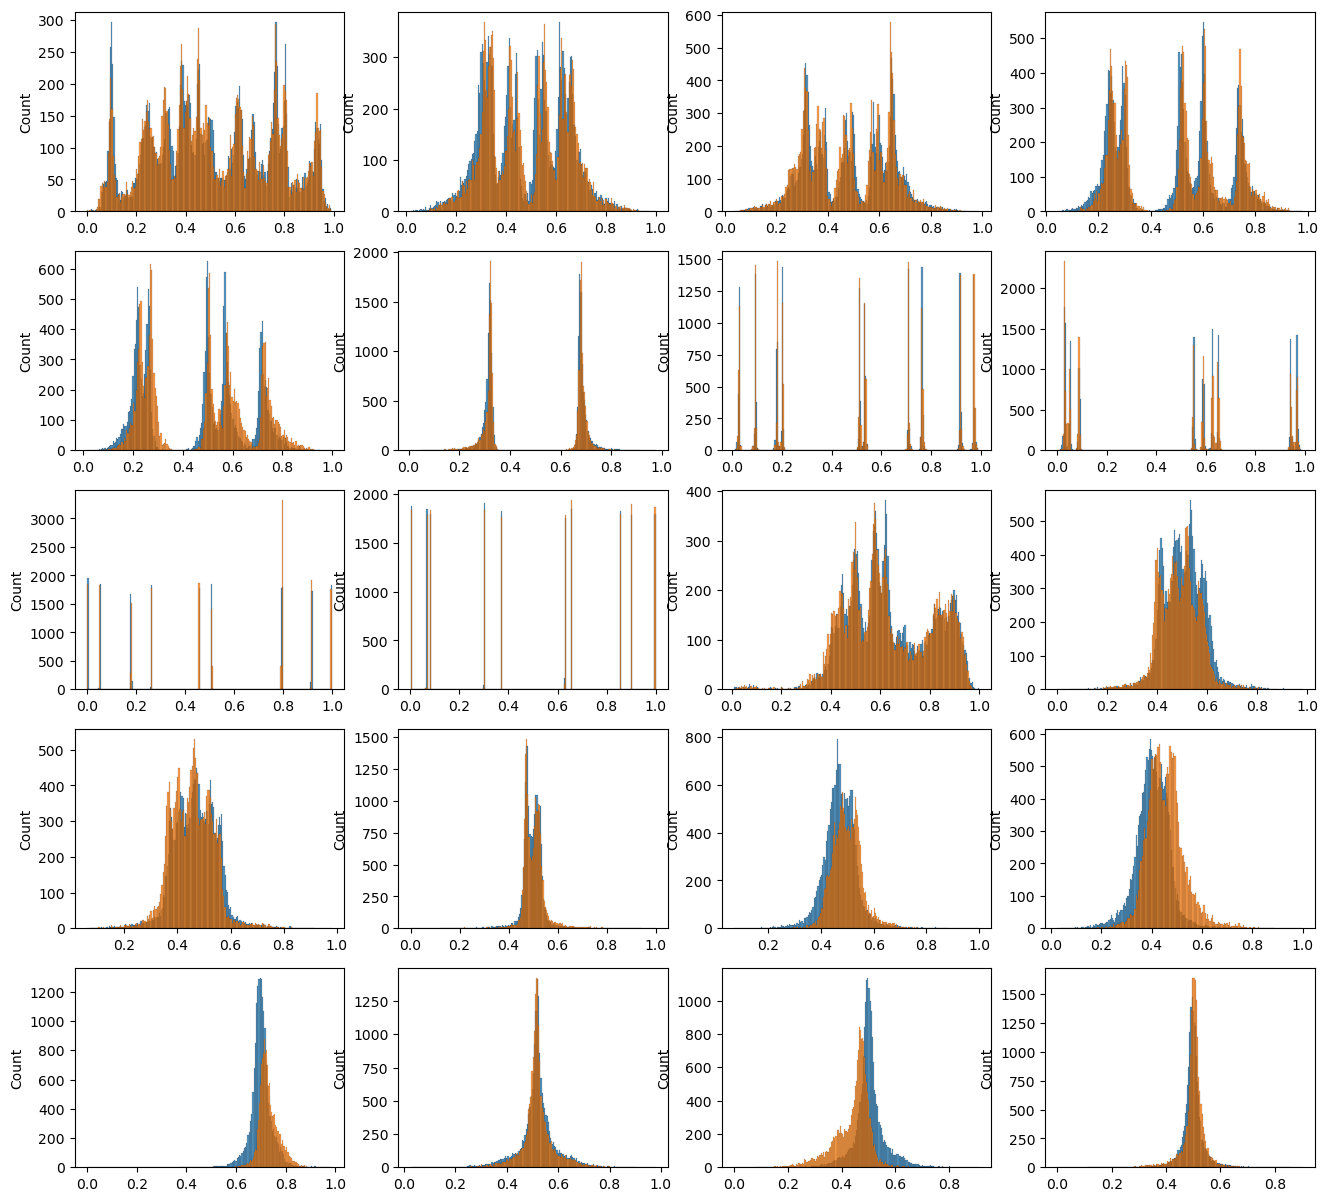

In [65]:
n_cols = 4
n_rows = data0.shape[1] // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), squeeze=False)
for feature_idx in range(data0.shape[1]):
    ax = axes[feature_idx // n_cols, feature_idx % n_cols]
    sns.histplot(data0[:, feature_idx], ax=ax, label='0', bins = 200)
    sns.histplot(data1[:, feature_idx], ax=ax, label='1', bins = 200)
plt.show()

In [ ]:
data.corrwith(data[data_config['target']]).sort_values(ascending=False)

### Low correlated Feature 0, 1, 2, 3

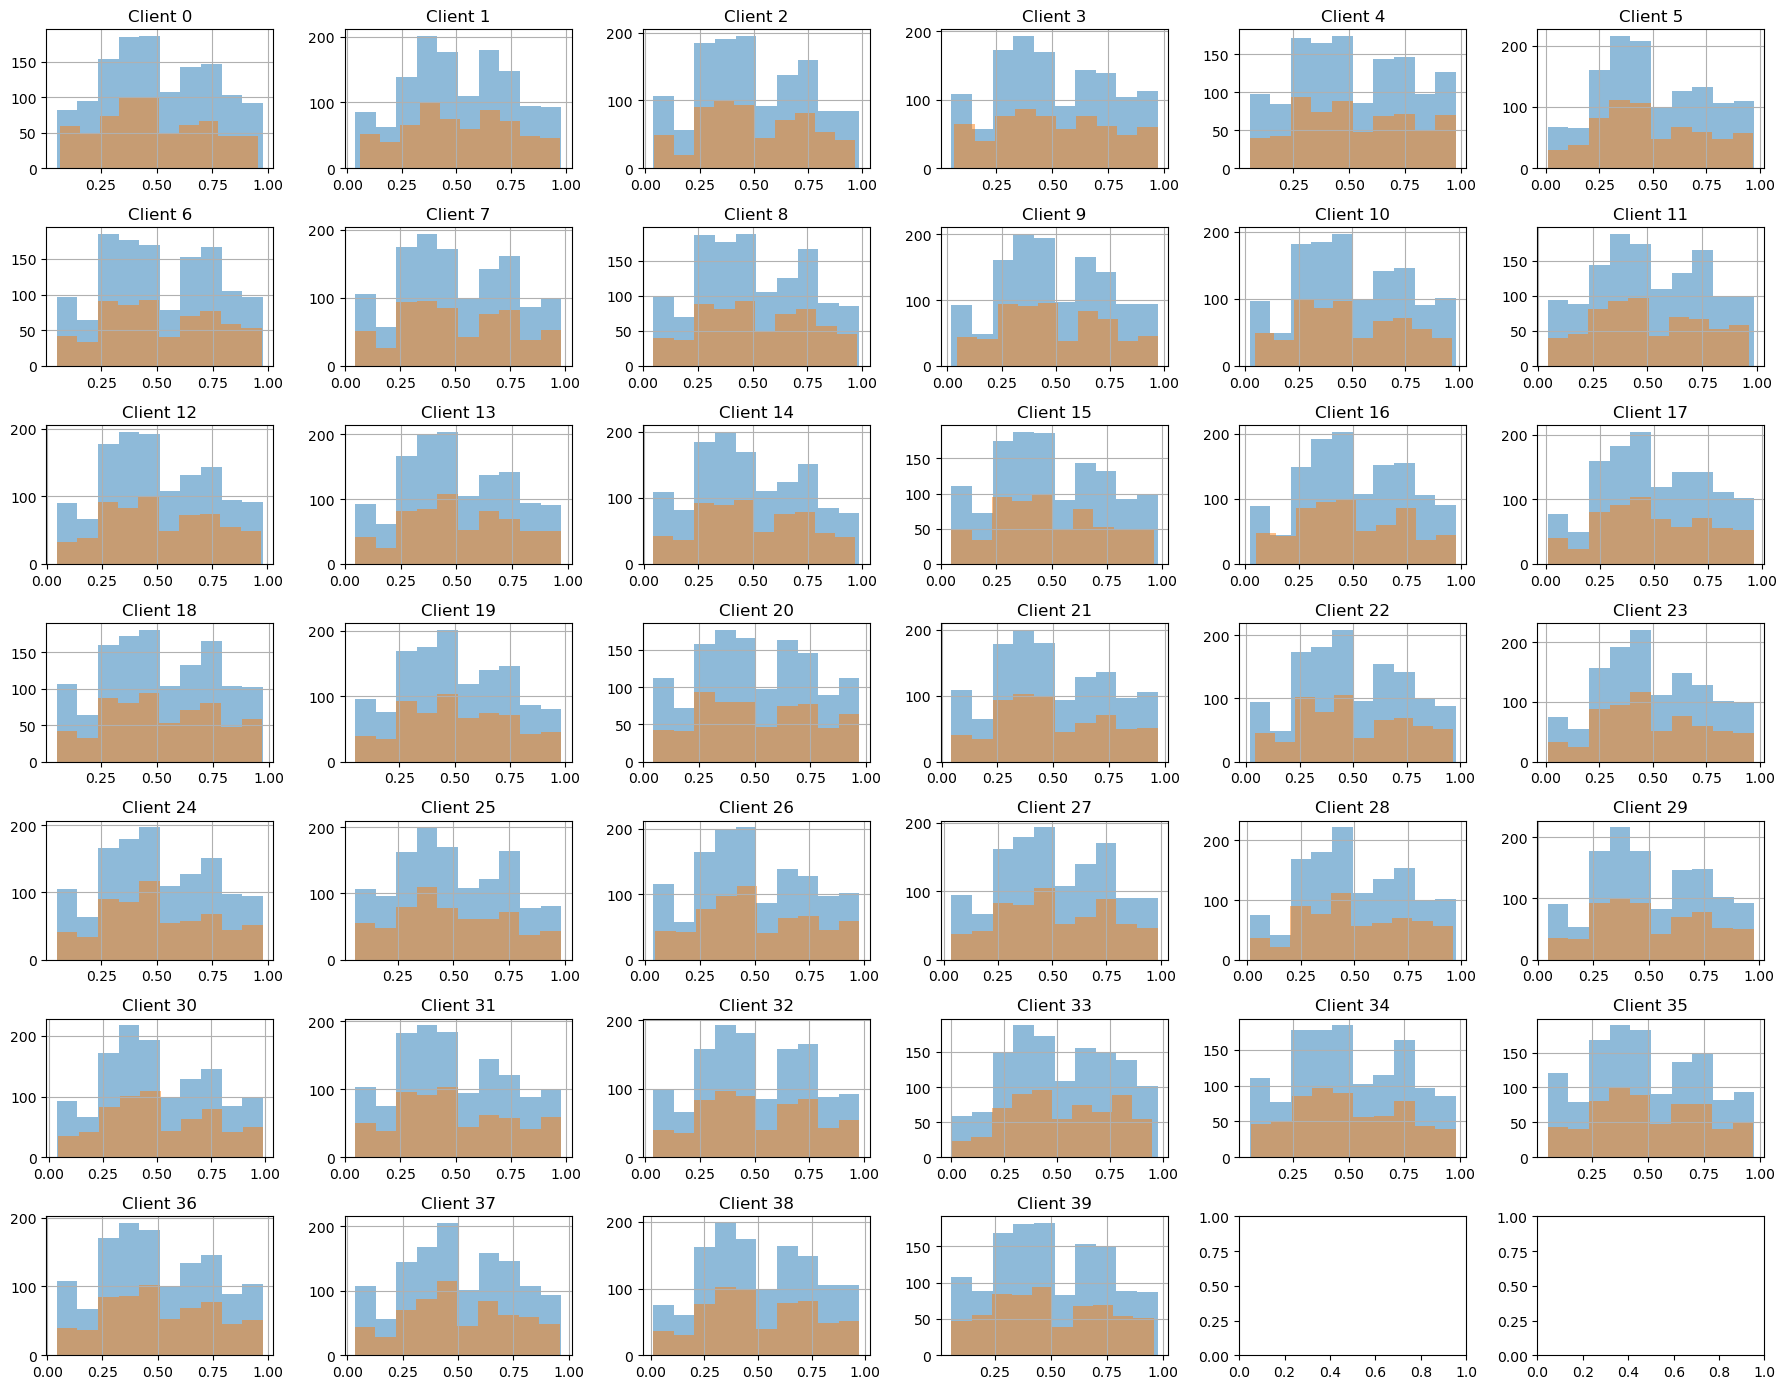

In [71]:
show_missing_mech(datas, msks, 0)

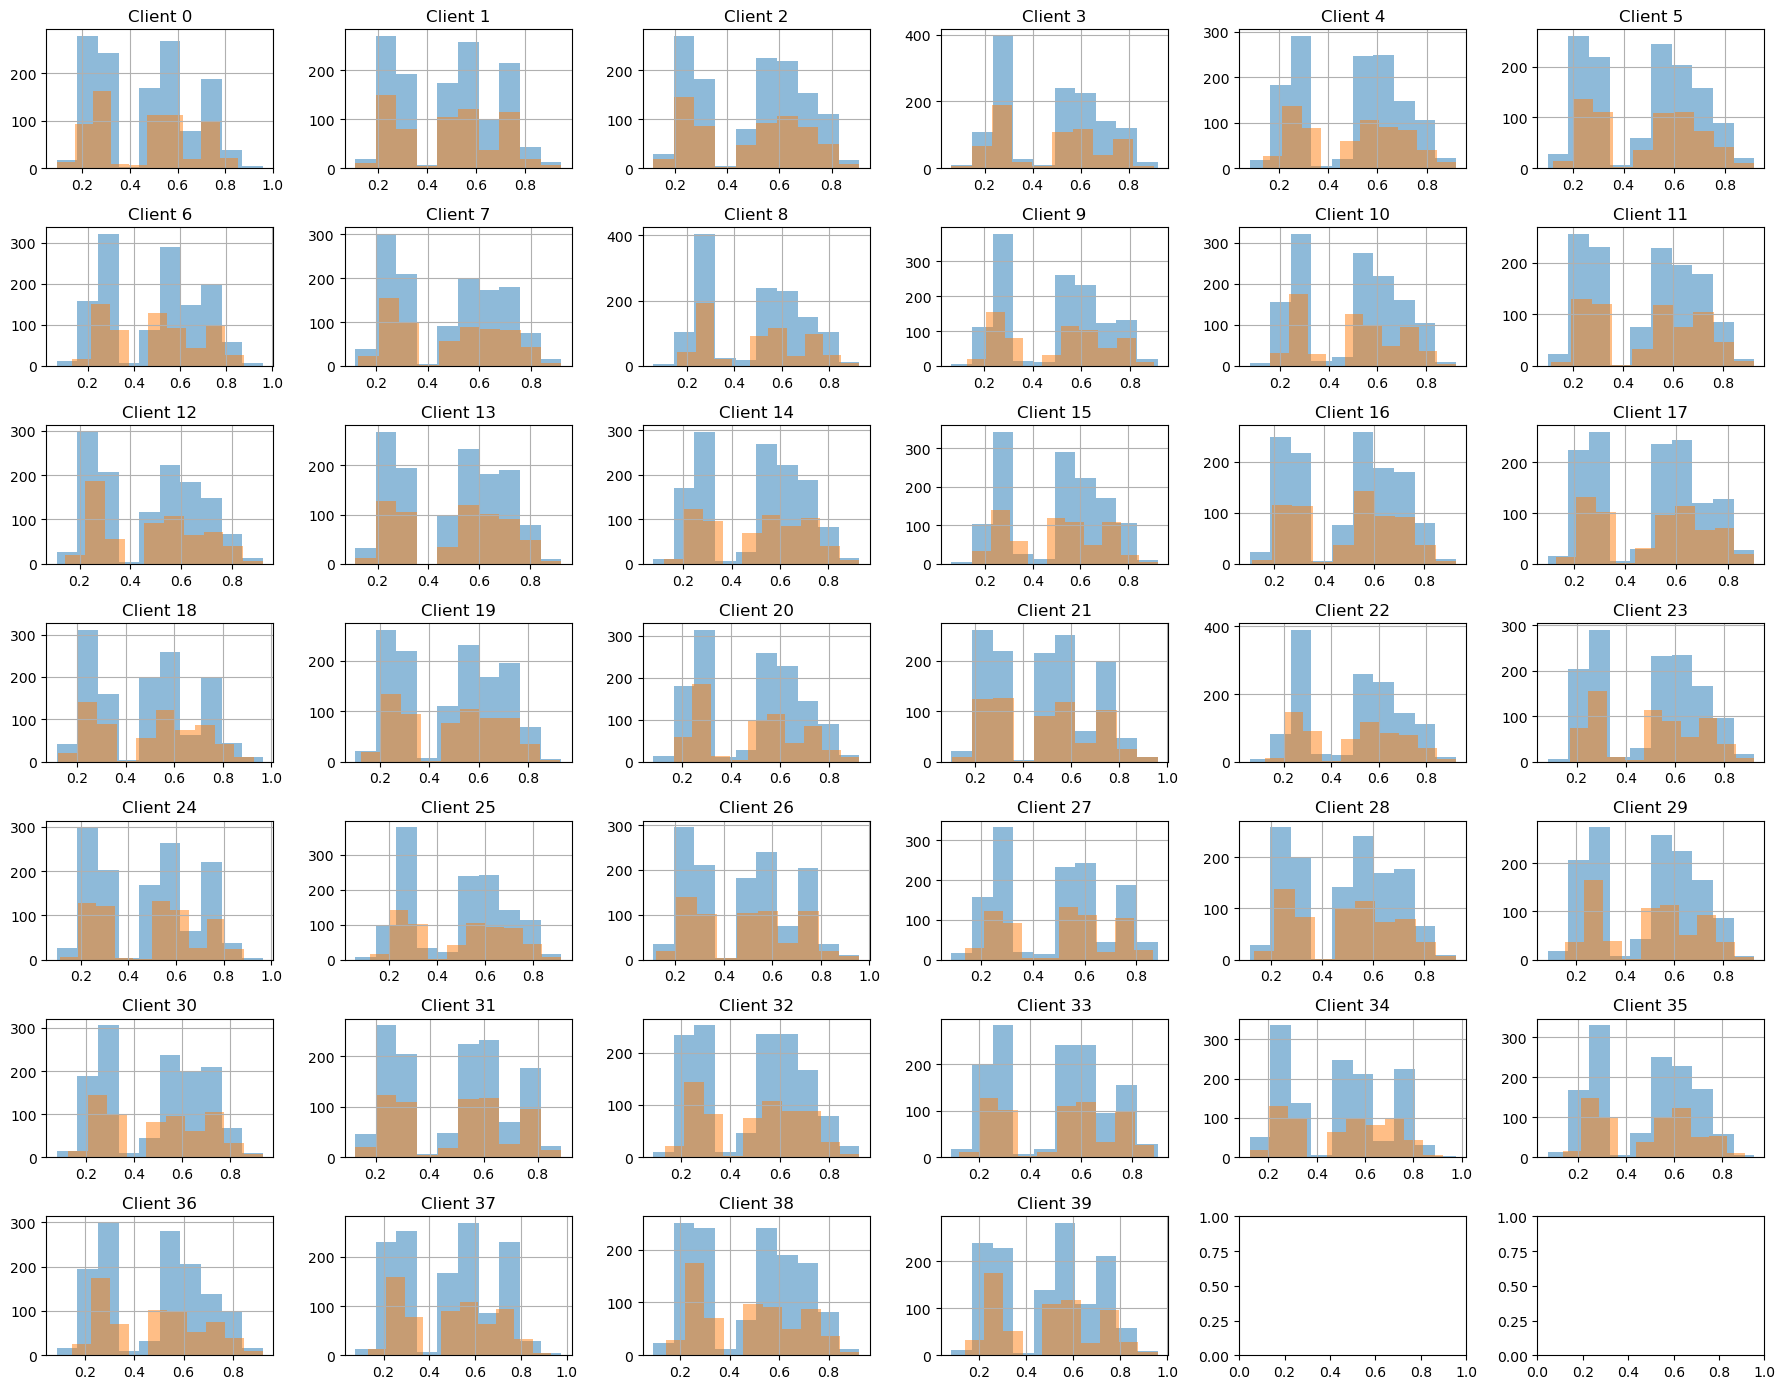

In [72]:
show_missing_mech(datas, msks, 3)

### Middle Correlated Feature 14, 15, 16, 18

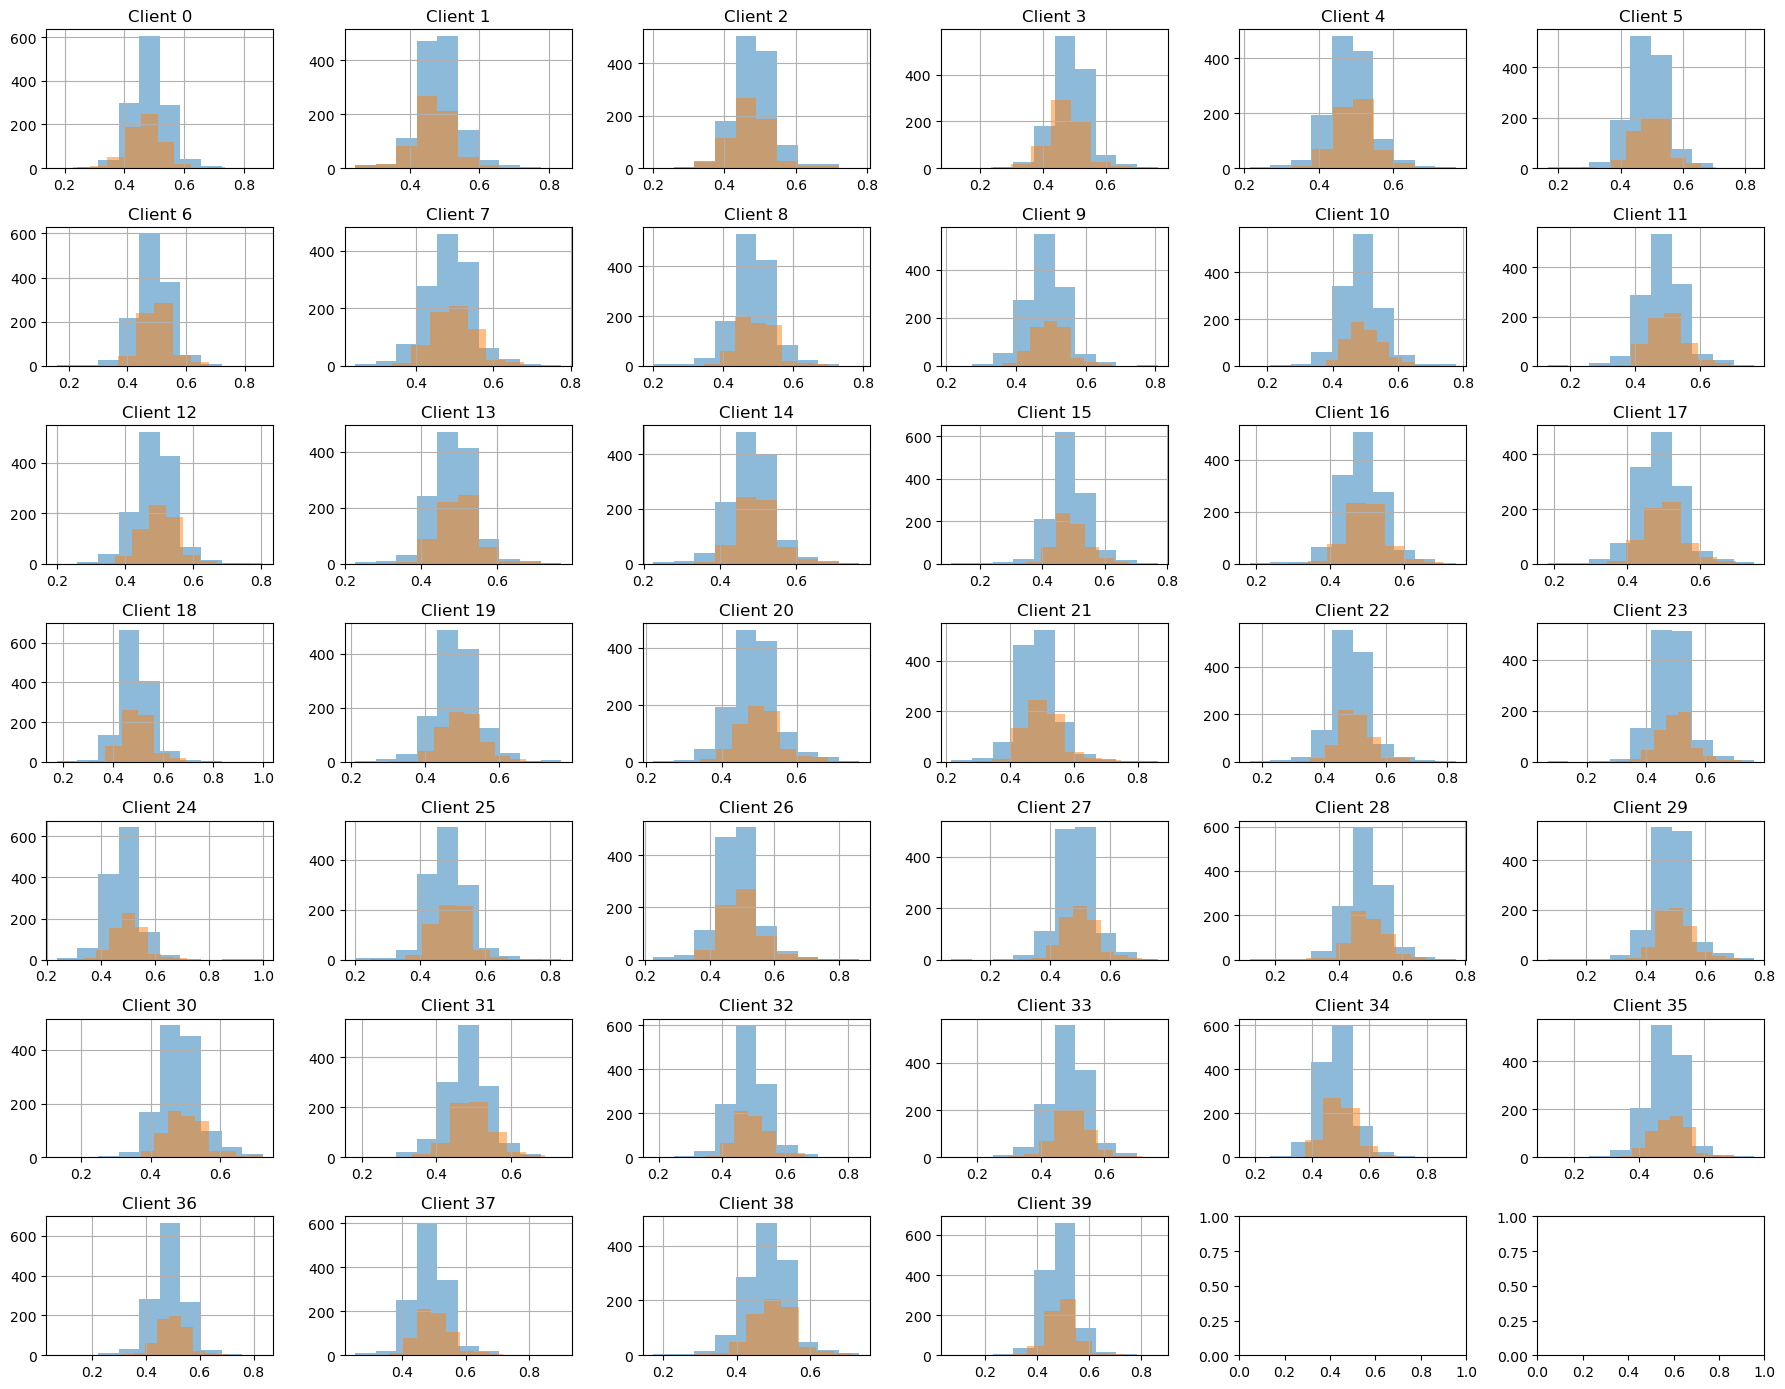

In [73]:
show_missing_mech(datas, msks, 14)

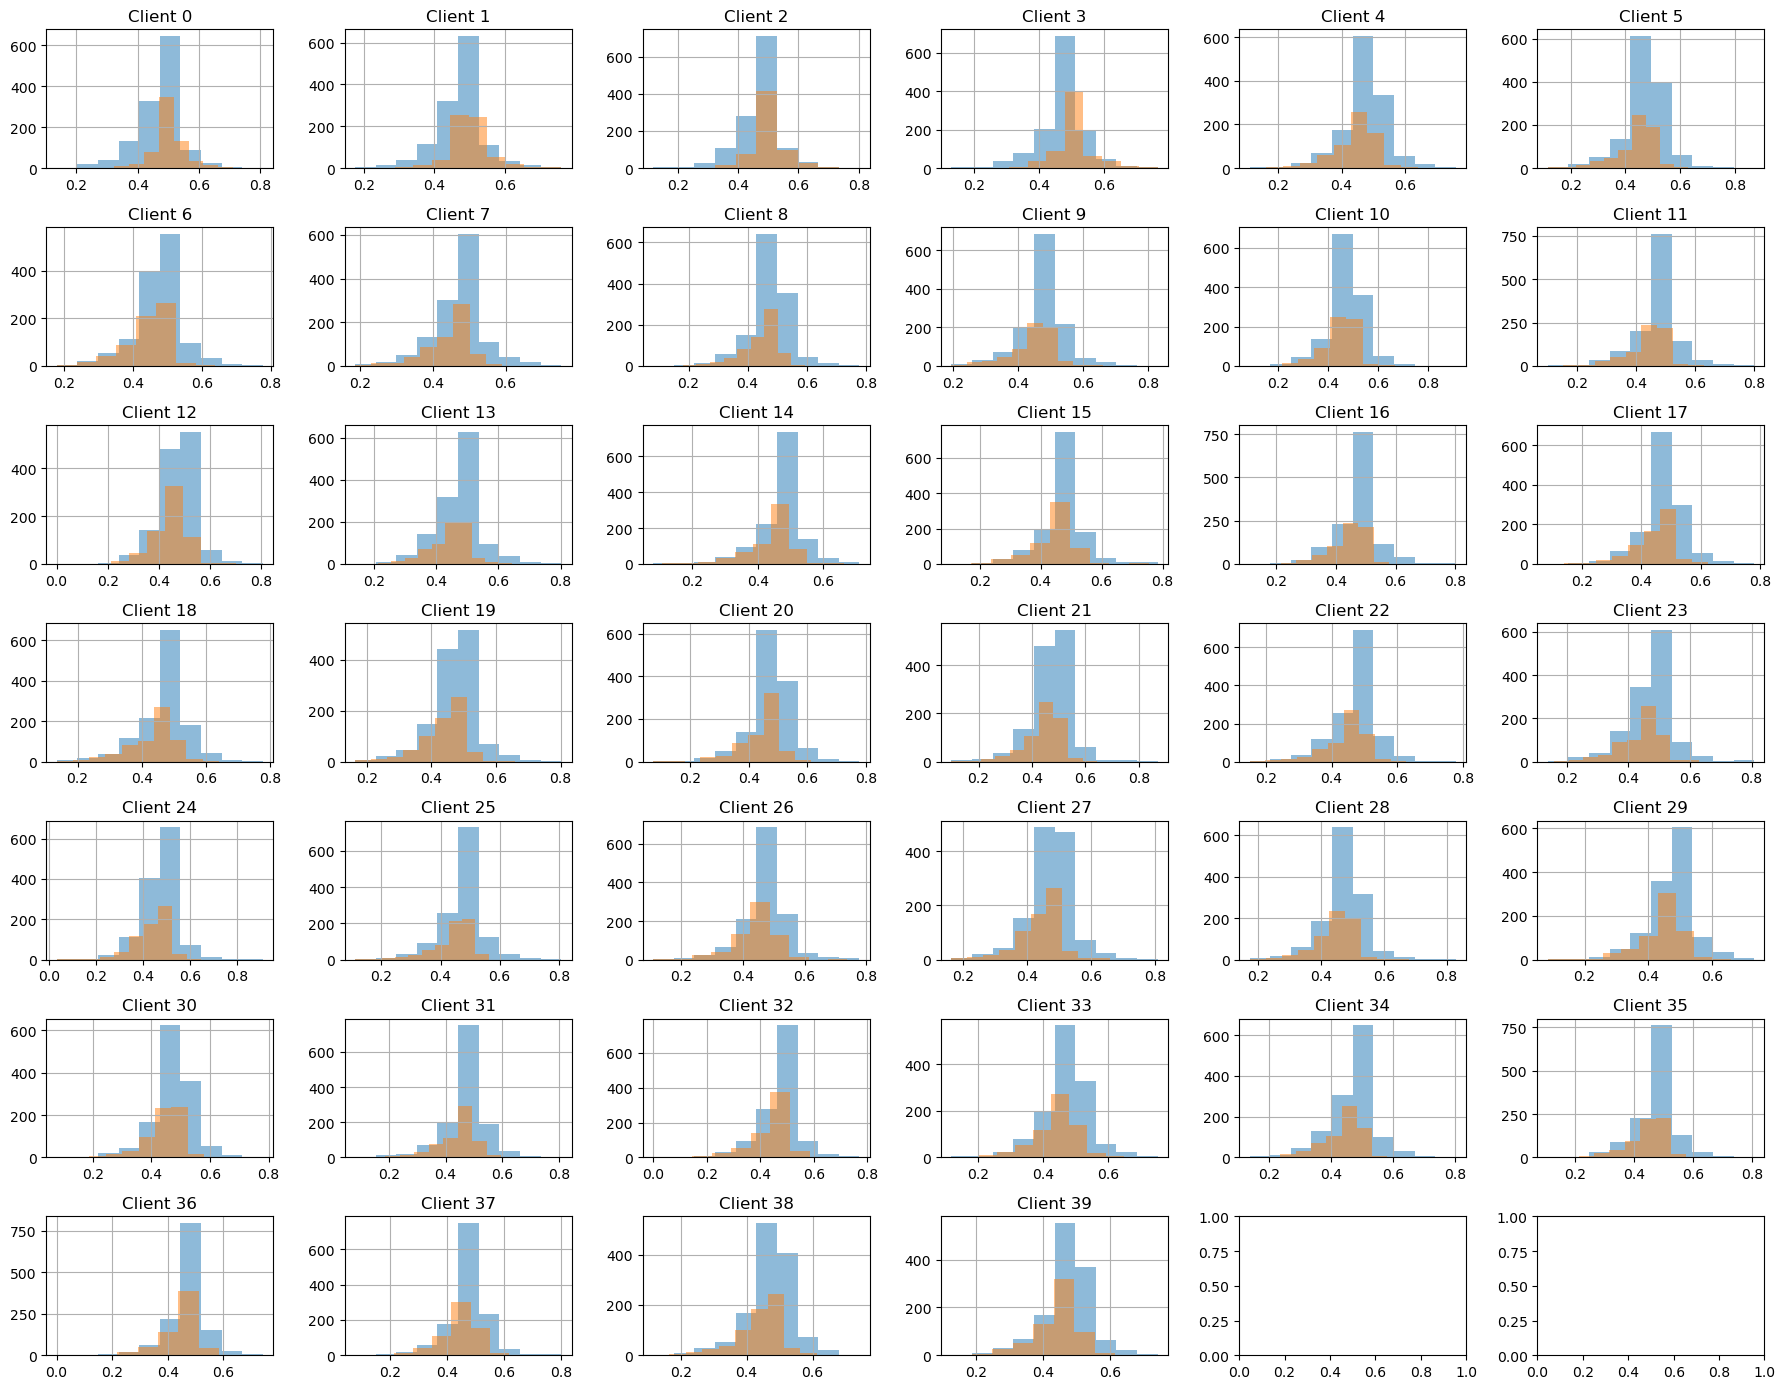

In [74]:
show_missing_mech(datas, msks, 18)

## IRIS

In [75]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'iris'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.8'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

datamss = [client.X_train_ms for client in clients.values()]
msks = [client.missing_mask for client in clients.values()]
datas = [np.concatenate([client.X_train, client.y_train.reshape(-1,1)], axis = 1) for client in clients.values()]

sample {'p': '0.8'}
['mary_left' 'mary_left' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right']


In [76]:
data.corrwith(data[data_config['target']]).sort_values(ascending=False)

5    1.000000
4    0.956464
3    0.949043
1    0.782561
2   -0.419446
dtype: float64

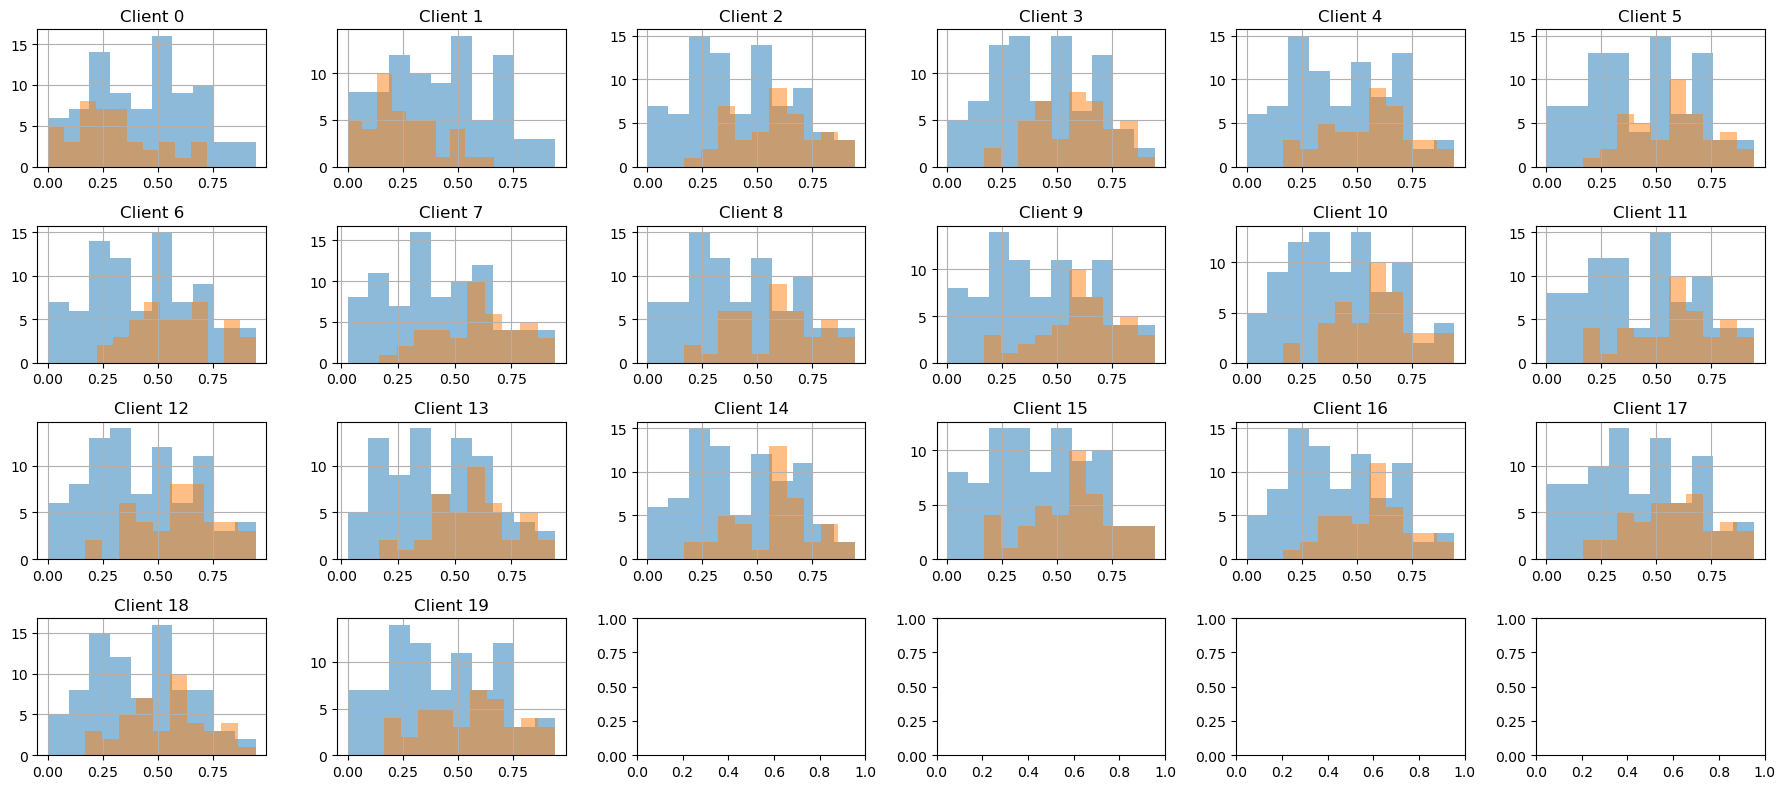

In [77]:
show_missing_mech(datas, msks, 0)

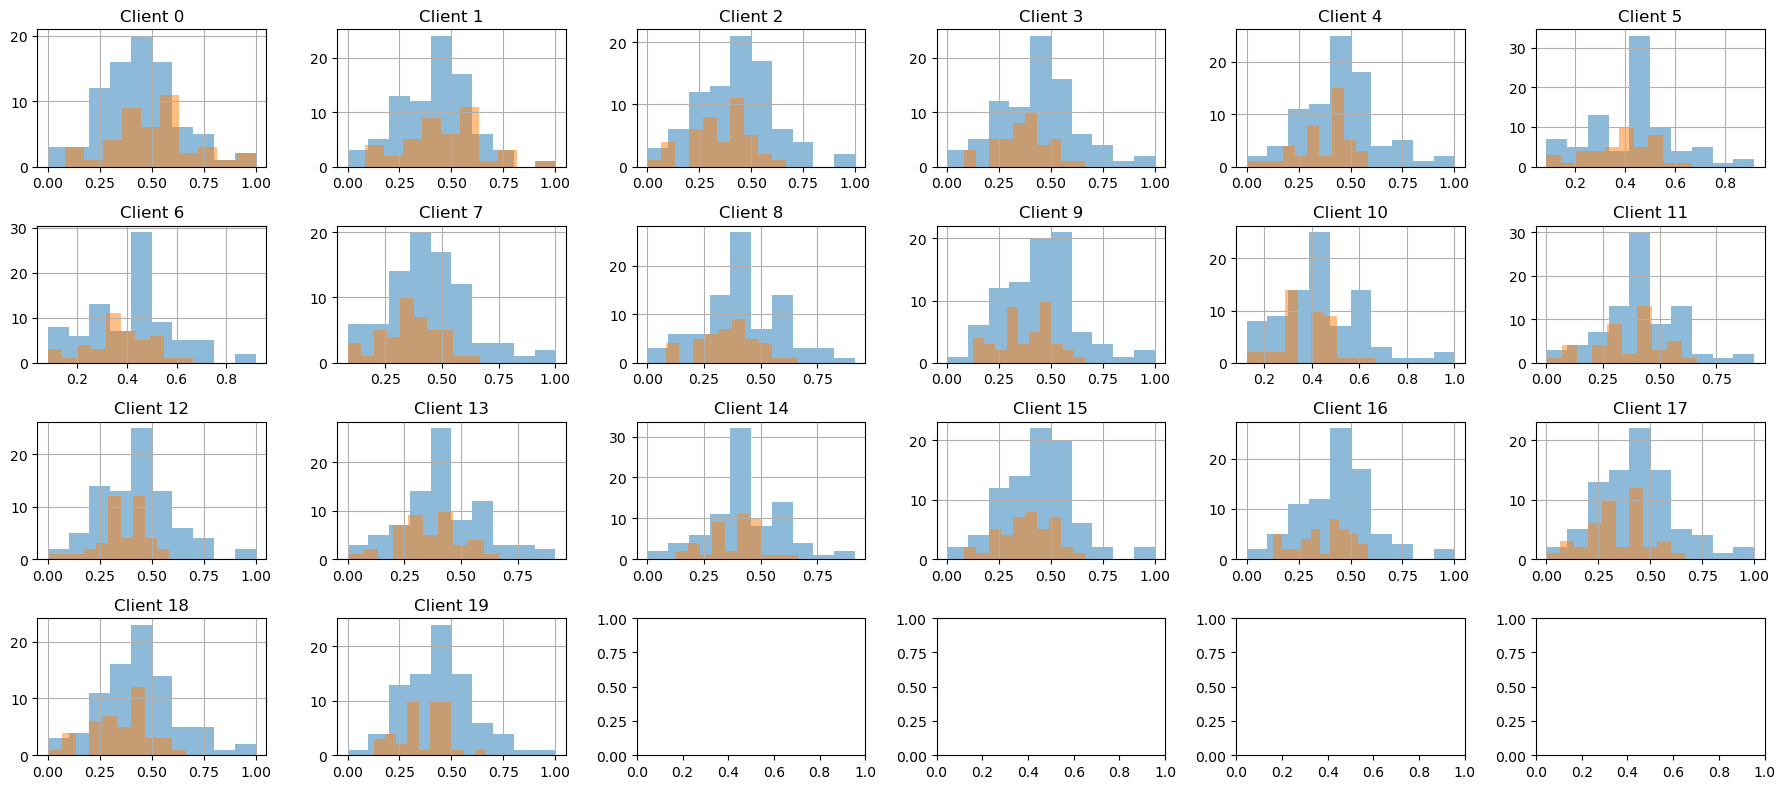

In [78]:
show_missing_mech(datas, msks, 1)

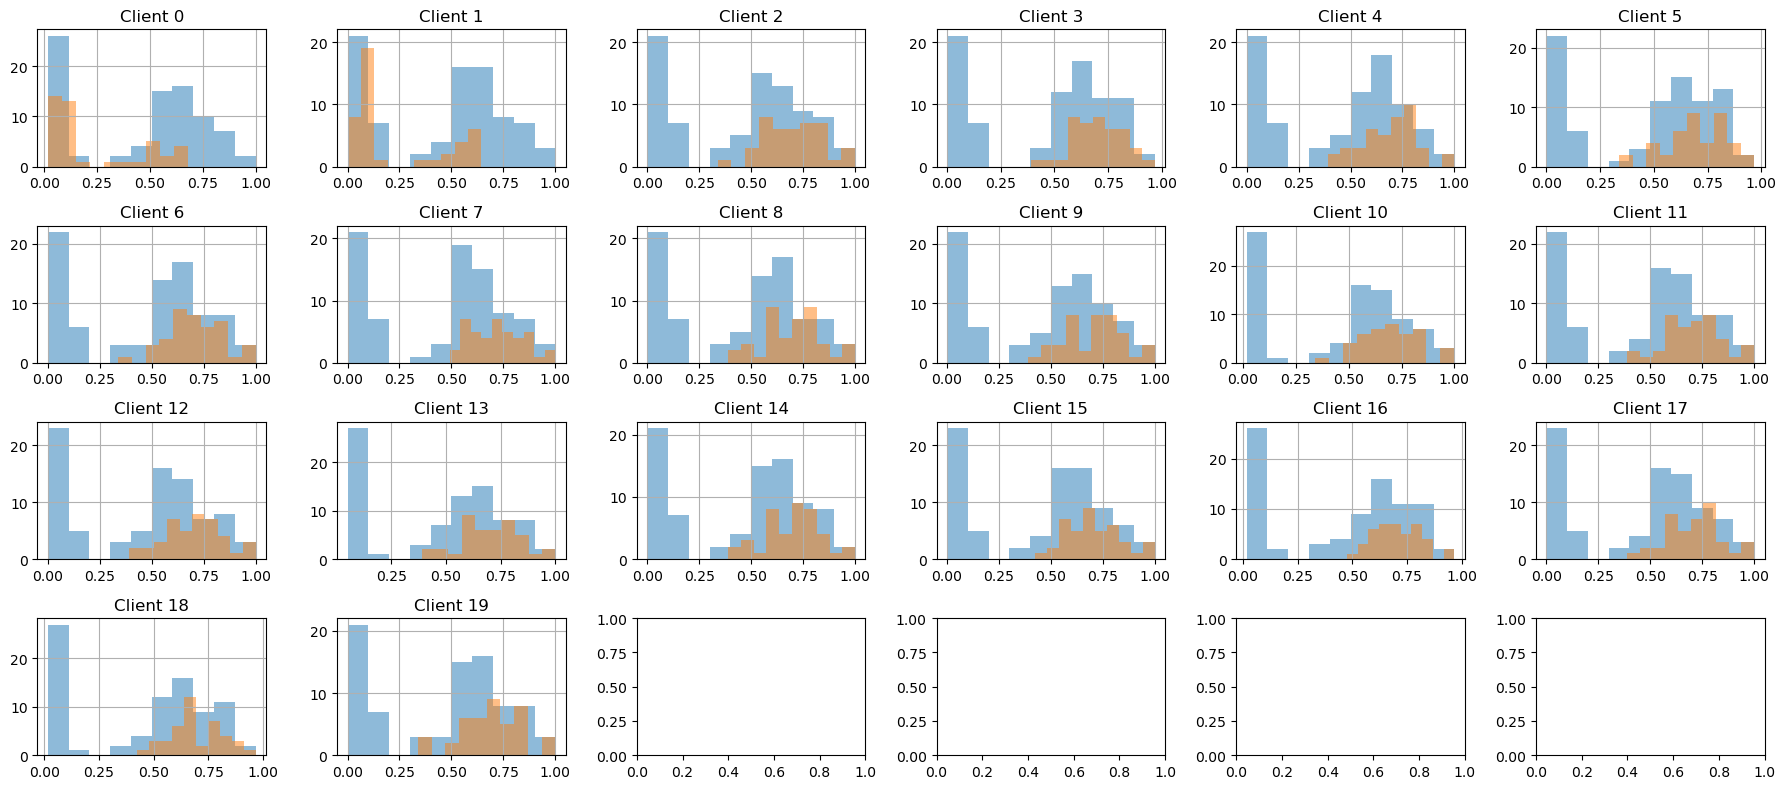

In [79]:
show_missing_mech(datas, msks, 2)

## SVMGuide

In [80]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'svm_g'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.8'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

datamss = [client.X_train_ms for client in clients.values()]
msks = [client.missing_mask for client in clients.values()]
datas = [np.concatenate([client.X_train, client.y_train.reshape(-1,1)], axis = 1) for client in clients.values()]

sample {'p': '0.8'}
['mary_left' 'mary_left' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right']


In [81]:
data.corrwith(data[data_config['target']]).sort_values(ascending=False)

0    1.000000
3    0.238567
4   -0.520413
1   -0.677541
2   -0.780726
dtype: float64

In [82]:
data.head()

,1,2,3,4,0
0,0.400328,0.715548,0.378231,0.598933,0
1,0.551905,0.854477,0.557790,0.584033,0
2,0.332131,0.824225,0.416518,0.598319,0
3,0.369204,0.787156,0.603082,0.793380,0
4,0.660281,0.892503,0.595375,0.851246,0


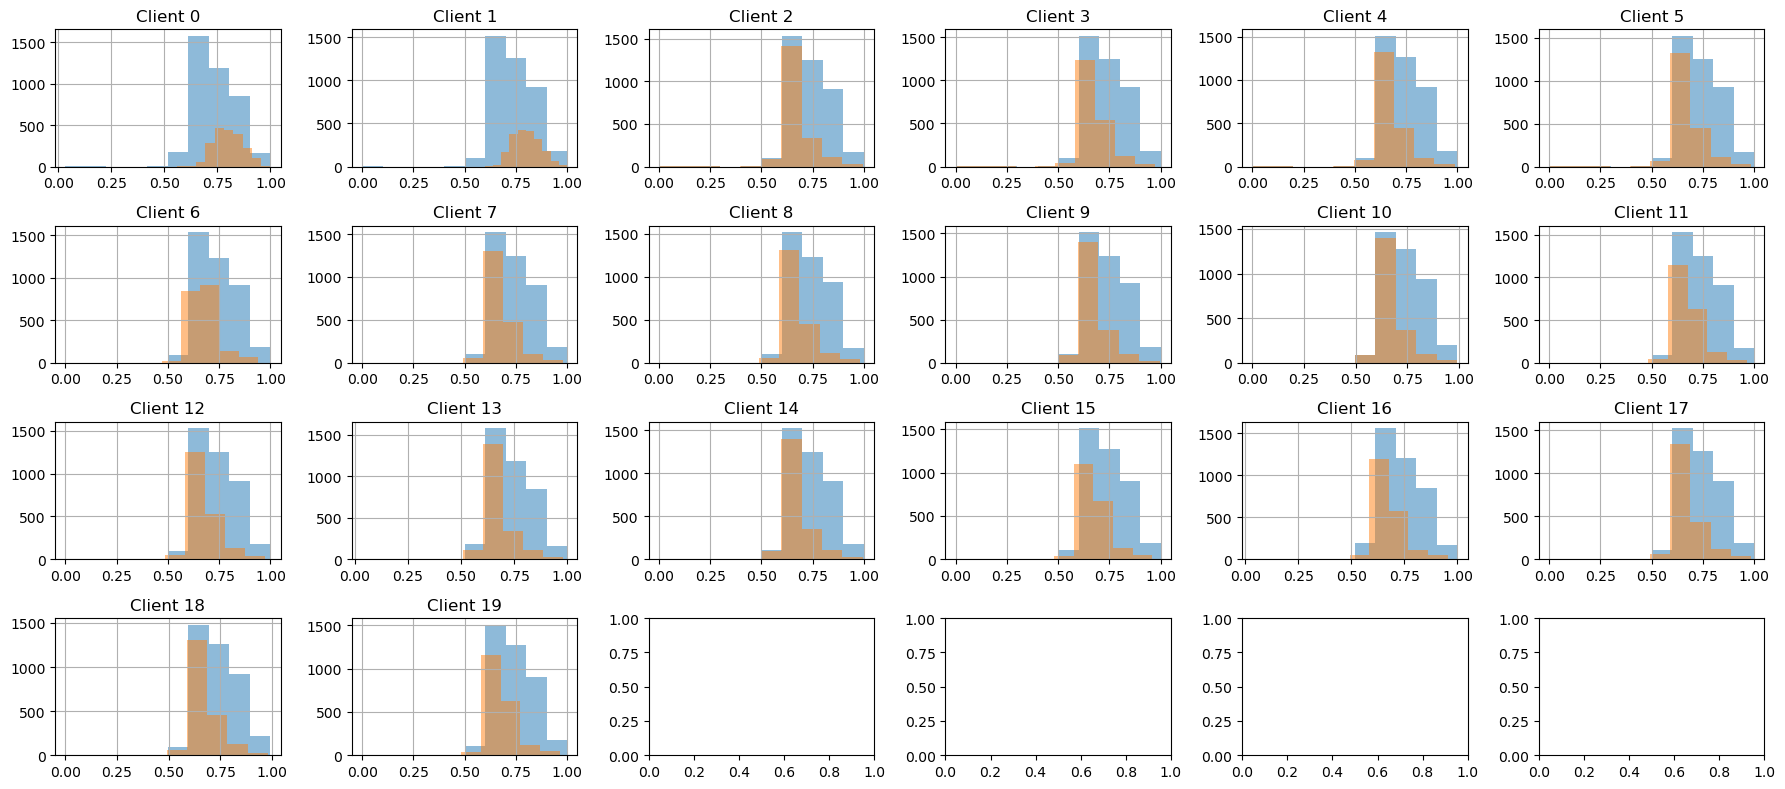

In [83]:
show_missing_mech(datas, msks, 1)

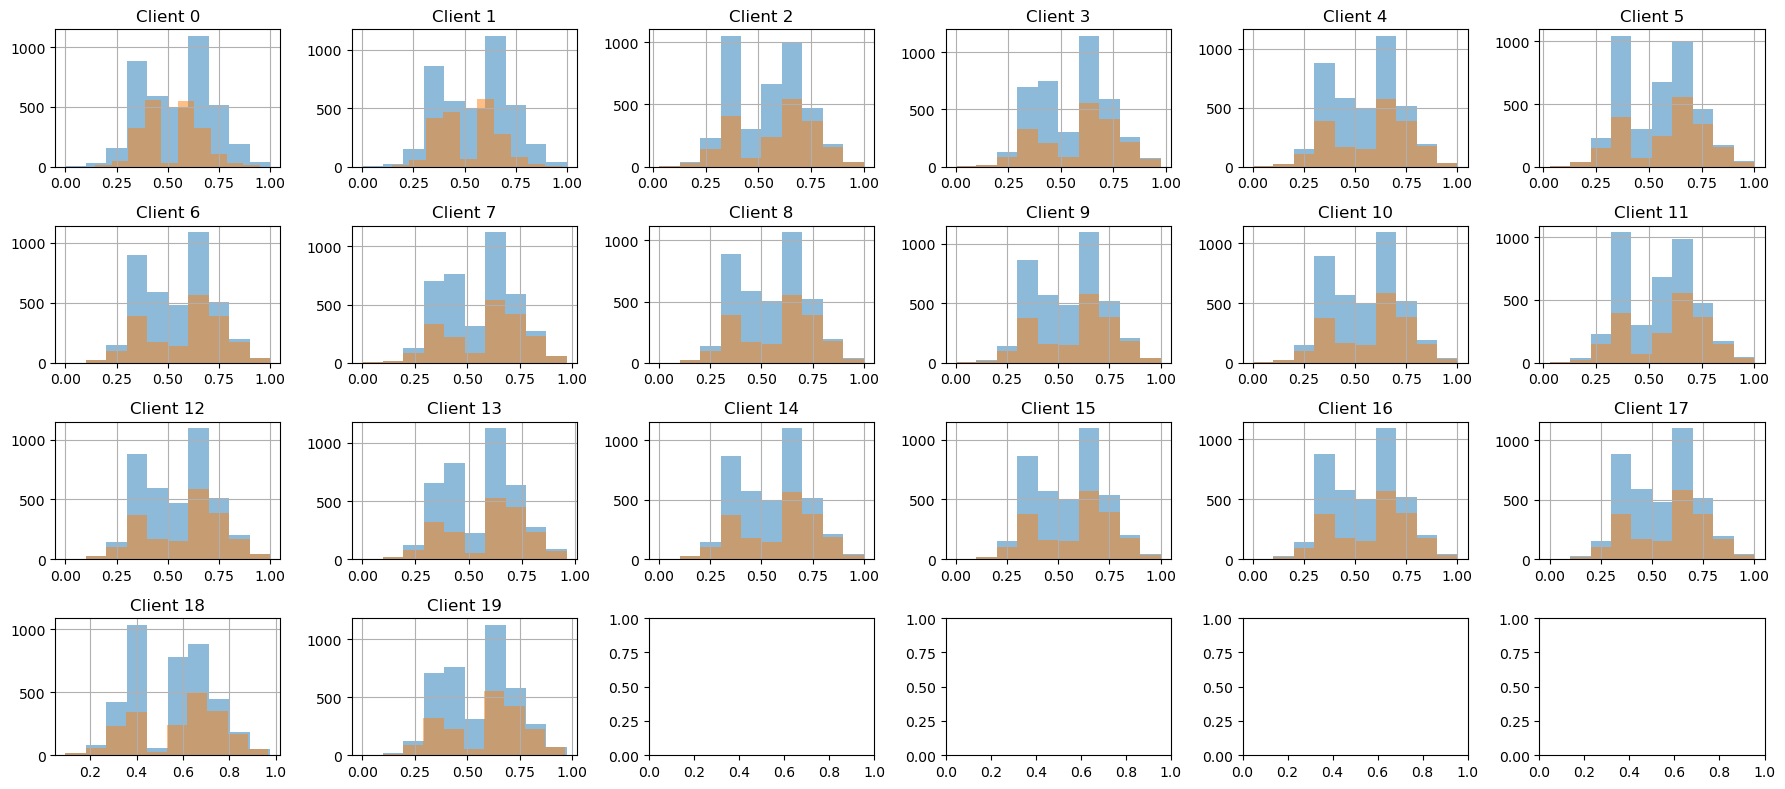

In [86]:
show_missing_mech(datas, msks, 2)